In [2]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader
from torch import nn, optim
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

device = torch.device("cuda:1") if torch.cuda.is_available() else torch.device("cpu")

In [3]:
'''
Code for early stopping from https://github.com/Bjarten/early-stopping-pytorch
'''

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            #self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [4]:
# Renaming y of the column by mapping each of the images to its output
# 0 - cavallo
# 1 - elefante
# 2 - farfalla
# 3 - gallina
# 4 - gatto

df1 = pd.read_csv('/content/cavallo.csv', header=None)
df1.rename(columns={0: 'y'}, inplace=True)
df1 = df1.assign(y=0)

df2 = pd.read_csv('/content/elefante.csv', header=None)
df2.rename(columns={0: 'y'}, inplace=True)
df2 = df2.assign(y=1)

df3 = pd.read_csv('/content/farfalla.csv', header=None)
df3.rename(columns={0: 'y'}, inplace=True)
df3 = df3.assign(y=2)

df4 = pd.read_csv('/content/gallina.csv', header=None)
df4.rename(columns={0: 'y'}, inplace=True)
df4 = df4.assign(y=3)

df5 = pd.read_csv('/content/gatto.csv', header=None)
df5.rename(columns={0: 'y'}, inplace=True)
df5 = df5.assign(y=4)

# Cleaning up the dataframe by deleting the last column
df1.drop(df1.columns[len(df1.columns)-1], axis=1, inplace=True)
df2.drop(df2.columns[len(df2.columns)-1], axis=1, inplace=True)
df3.drop(df3.columns[len(df3.columns)-1], axis=1, inplace=True)
df4.drop(df4.columns[len(df4.columns)-1], axis=1, inplace=True)
df5.drop(df5.columns[len(df5.columns)-1], axis=1, inplace=True)

frames = [df1, df2, df3, df4, df5]
df = pd.concat(frames)

In [5]:
X = df.drop(columns = ['y']).copy()
y = df['y']

X = np.array(X)
y = np.array(y)

# Since the sum of the rows for each of the categories are the same, normalising by it
X= X/X.sum(axis=1,keepdims=1)

In [6]:
class AANN1(nn.Module):
    def __init__(self):
        super().__init__()
          
        self.encoder = nn.Sequential(
            nn.Linear(48, 40),
            nn.Tanh(),
            nn.Linear(40, 32)
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 40),
            nn.Tanh(),
            nn.Linear(40, 48),
        )
          
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [7]:
class AANN2(nn.Module):
    def __init__(self):
        super().__init__()
          
        self.encoder = nn.Sequential(
            nn.Linear(32, 24),
            nn.Tanh(),
            nn.Linear(24, 16)
        )
        self.decoder = nn.Sequential(
            nn.Linear(16, 24),
            nn.Tanh(),
            nn.Linear(24, 32)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [8]:
class AANN3(nn.Module):
    def __init__(self):
        super().__init__()
          
        self.encoder = nn.Sequential(
            nn.Linear(16, 12),
            nn.Tanh(),
            nn.Linear(12, 8)
        )
        self.decoder = nn.Sequential(
            nn.Linear(8, 12),
            nn.Tanh(),
            nn.Linear(12, 16)
        )
  
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [9]:
'''
Method to train the three auto associative neural networks to create a stacked encoder
'''
def TrainAE(lr1, lr2, lr3):
  '''
  Training the first layer of the autoencoder
  '''
  SAE1 = AANN1()
  SAE1.to(device)

  loss_function = nn.MSELoss(reduction = 'mean')
  optimizer = optim.Adam(SAE1.parameters(), lr = lr1)
  early_stopping = EarlyStopping(patience=10)

  epochs = 100
  losses = []
  avg_test_loss = []
  for epoch in range(epochs):
    SAE1.train()
    for (histogram, _) in train_dataloader:      
      # Moving histogram to device memory
      histogram = histogram.type(torch.float32).to(device)
      optimizer.zero_grad()
      # Output of Autoencoder
      reconstructed = SAE1(histogram)
      reconstructed = reconstructed.squeeze()
      # Calculating the loss
      histogram = histogram.squeeze()
      loss = loss_function(reconstructed, histogram)
        
      loss.backward()
      optimizer.step()
        
      # Storing the losses in a list for plotting
      losses.append(loss.detach().cpu().numpy())
    
    test_losses = []
    SAE1.eval() # prep model for evaluation
    for histogram, _ in test_dataloader:
      histogram = histogram.type(torch.float32).to(device)
      reconstructed = SAE1(histogram)
      reconstructed = reconstructed.squeeze()
      # calculate the loss
      loss = loss_function(reconstructed, histogram)
      # record validation loss
      test_losses.append(loss.item())
    
    avg_test_loss.append(np.average(test_losses))
    early_stopping(avg_test_loss[-1], SAE1)
          
    if early_stopping.early_stop:
      print("Early stopping")
      break

  # Plotting average training loss
  plt.figure()
  plt.style.use('fivethirtyeight')
  plt.xlabel('Iterations')
  plt.ylabel('Loss')
  plt.title('Training Loss vs Iterations for AANN1')
  plt.plot(losses[:100])

  # Plotting average test loss
  plt.figure()
  plt.style.use('fivethirtyeight')
  plt.xlabel('Iterations')
  plt.ylabel('Loss')
  plt.title('Average Test Loss vs Iterations for AANN1')
  plt.plot(avg_test_loss[:100])

  '''
  Training the second layer of the autoencoder
  '''

  # Freeze the weights of the first stacked encoder
  SAE1.eval()
  SAE2 = AANN2()
  SAE2.to(device)

  loss_function = nn.MSELoss(reduction = 'mean')
  optimizer = optim.Adam(SAE2.parameters(), lr = lr2, weight_decay = 1e-8)

  epochs = 100
  losses = []
  avg_test_loss = []
  for epoch in range(epochs):
    SAE2.train()
    for (histogram, _) in train_dataloader:      
      histogram = histogram.type(torch.float32).to(device)
      optimizer.zero_grad()

      # Output of Autoencoder1
      output_intermediate = SAE1.encoder(histogram)
      # Ouptput of Autoencoder 2
      reconstructed = SAE2(output_intermediate)
      reconstructed = reconstructed.squeeze()
      
      # Calculating the loss
      output_intermediate = output_intermediate.squeeze()
      loss = loss_function(reconstructed, output_intermediate)

      loss.backward()
      optimizer.step()
      losses.append(loss.detach().cpu().numpy())
    
    test_losses = []
    SAE2.eval() # prep model for evaluation
    for histogram, _ in test_dataloader:
      histogram = histogram.type(torch.float32).to(device)
      output_intermediate = SAE1.encoder(histogram)
      reconstructed = SAE2(output_intermediate)
      reconstructed = reconstructed.squeeze()
      # calculate the loss
      loss = loss_function(reconstructed, output_intermediate)
      # record validation loss
      test_losses.append(loss.item())
    
    avg_test_loss.append(np.average(test_losses))
    early_stopping(avg_test_loss[-1], SAE2)
          
    if early_stopping.early_stop:
      print("Early stopping")
      break
    
  # Plotting average training loss
  plt.figure()
  plt.style.use('fivethirtyeight')
  plt.xlabel('Iterations')
  plt.ylabel('Loss')
  plt.title('Training Loss vs Iterations for AANN2')
  plt.plot(losses[:100])


  '''
  Training the third layer of the autoencoder
  '''
  SAE3 = AANN3()
  SAE3.to(device)
  loss_function = nn.MSELoss(reduction = 'mean')
    
  optimizer = optim.Adam(SAE3.parameters(), lr = lr3, weight_decay = 1e-8)

  epochs = 10
  losses = []
  avg_test_loss = []
  SAE1.eval()
  SAE2.eval()
  for epoch in range(epochs):
    SAE3.train()
    for (histogram, _) in train_dataloader:
      histogram = histogram.type(torch.float32).to(device)
      optimizer.zero_grad()

      output_1 = SAE1.encoder(histogram)
      output_intermediate = SAE2.encoder(output_1)
      reconstructed = SAE3(output_intermediate)
      reconstructed = reconstructed.squeeze()
      # Calculating the loss
      output_1 = output_1.squeeze()
      loss = loss_function(reconstructed, output_intermediate)
        
      # The gradients are set to zero,
      # the the gradient is computed and stored.
      # .step() performs parameter update
      loss.backward()
      optimizer.step()
        
      # Storing the losses in a list for plotting
      losses.append(loss.detach().cpu().numpy())

    test_losses = []
    SAE3.eval() # prep model for evaluation
    for histogram, _ in test_dataloader:
      histogram = histogram.type(torch.float32).to(device)
      output_1 = SAE1.encoder(histogram)
      output_intermediate = SAE2.encoder(output_1)
      reconstructed = SAE3(output_intermediate)
      reconstructed = reconstructed.squeeze()
      # calculate the loss
      loss = loss_function(reconstructed, output_intermediate)
      # record validation loss
      test_losses.append(loss.item())
    
    avg_test_loss.append(np.average(test_losses))
    early_stopping(avg_test_loss[-1], SAE3)
          
    if early_stopping.early_stop:
      print("Early stopping")
      break
    
  # Plotting the training loss
  plt.figure()
  plt.style.use('fivethirtyeight')
  plt.xlabel('Iterations')
  plt.ylabel('Loss')
  plt.title('Training Loss vs Iterations for AANN3')
  plt.plot(losses[:100])

  return SAE1, SAE2, SAE3

In [10]:
class StackedAutoEncoder(nn.Module):
    def __init__(self):
        super(StackedAutoEncoder, self).__init__()
        SAE1.train()
        SAE2.train()
        SAE3.train()
        self.ae1 = SAE1.encoder
        self.ae2 = SAE2.encoder
        self.ae3 = SAE3.encoder
        self.DNN = nn.Linear(8, 5)
            
    def forward(self, x):
        a1 = self.ae1(x)
        a2 = self.ae2(a1)
        a3 = self.ae3(a2)
        output = self.DNN(a3)
        return output

Early stopping
Early stopping

BATCH SIZE: 16 	LR1: 3e-05 	LR2: 3e-05 	LR3: 3e-05
Train average loss: 1.28536
Test average loss: 1.30136
Test Accuracy: 0.47260

Early stopping
Early stopping

BATCH SIZE: 32 	LR1: 3e-05 	LR2: 3e-05 	LR3: 3e-05
Train average loss: 1.30393
Test average loss: 1.30387
Test Accuracy: 0.46667



,BATCH_SIZE,LR1,LR2,LR3,Test Accuracy
0,16,0.00003,0.00003,0.00003,0.472603
1,32,0.00003,0.00003,0.00003,0.466667


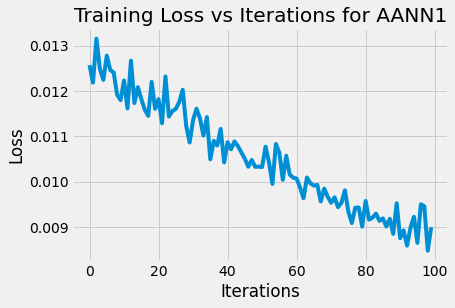

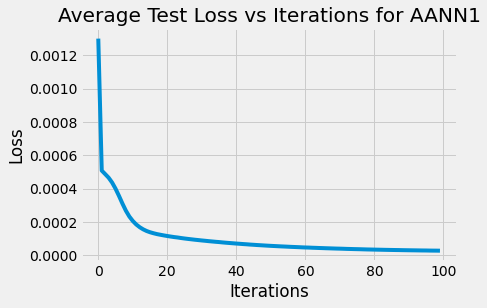

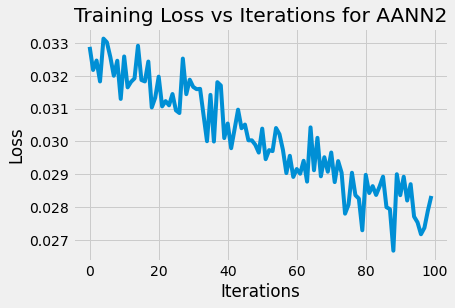

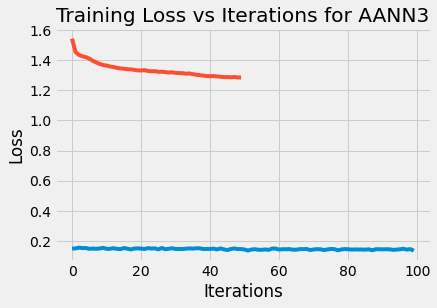

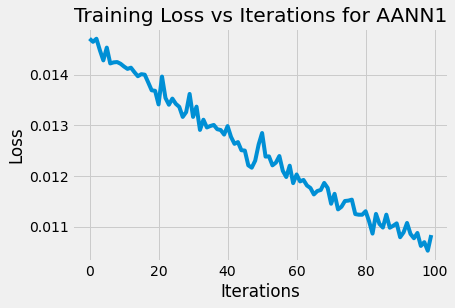

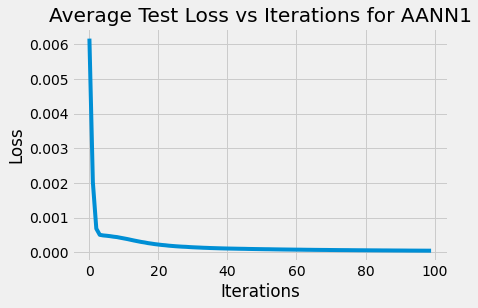

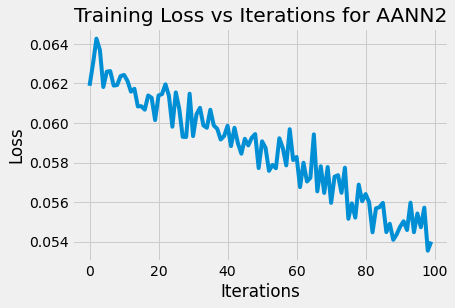

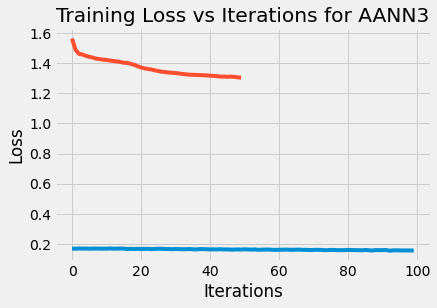

In [45]:
batch_sizes = [8, 16, 32]
LR = [3e-3, 3e-4, 3e-5]
metrics_df = pd.DataFrame(columns=['BATCH_SIZE', 'LR1', 'LR2', 'LR3', 'Test Accuracy'])
for BATCH_SIZE in batch_sizes:
  for lr1 in LR:
    for lr2 in LR:
      for lr3 in LR:
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify = y)
        train_dataloader = DataLoader(TensorDataset(torch.tensor(X_train), torch.tensor(y_train)), batch_size = BATCH_SIZE, shuffle = True)
        test_dataloader = DataLoader(TensorDataset(torch.tensor(X_test), torch.tensor(y_test)), batch_size = BATCH_SIZE, shuffle = True)
        SAE1, SAE2, SAE3 = TrainAE(lr1, lr2, lr3)

        # Defining the stacked encoder network
        model = StackedAutoEncoder()
        model.to(device)
        loss_function = nn.CrossEntropyLoss(reduction = 'mean')
        optimizer = optim.Adam(model.parameters(), lr = 9e-4, weight_decay = 1e-8)

        train_loss_list = list()
        epochs = 50
        accuracy_metrics = {
          'train': [],
          'test': []
        }

        for epoch in range(epochs):
          temp_loss_list = list()
          correct_classified = 0
          for x_train, y_train in train_dataloader:
            model.train()
            x_train = x_train.type(torch.float32).to(device)
            y_train = y_train.type(torch.long).to(device)
            optimizer.zero_grad()

            # Output of Autoencoder
            output = model(x_train)
            # Calculating the loss function
            loss = loss_function(output, y_train)
            loss.backward()
            optimizer.step()
            temp_loss_list.append(loss.detach().cpu().numpy())
            max_indices = torch.argmax(output, dim=1)
            correct_classified +=  (max_indices == y_train).float().sum()
                
              # Storing the losses in a list for plotting
          train_loss_list.append(np.average(temp_loss_list))
          accuracy_metrics["train"].append(correct_classified.item() / len(train_dataloader.dataset))
          if (epoch+1)%100 == 0:
            print("epoch:", epoch)
            print("Train Accuracy: %.5f" %(correct_classified.item() / len(train_dataloader.dataset)))
        
        correct_classified = 0
        model.eval()
        test_loss_list = list()
        for X_test, y_test in test_dataloader:
          X_test = X_test.type(torch.float32).to(device)
          y_test = y_test.type(torch.long).to(device)

          score = model(X_test)
          loss = loss_function(input=score, target=y_test)

          test_loss_list.append(loss.detach().cpu().numpy())
          max_indices = torch.argmax(score, dim=1)
          correct_classified +=  (max_indices == y_test).float().sum()

        accuracy_metrics["test"].append(correct_classified.item() / len(test_dataloader.dataset))
        test_loss_list.append(np.average(test_loss_list))

        print()
        print("BATCH SIZE:", BATCH_SIZE, "\tLR1:", lr1, "\tLR2:", lr2, "\tLR3:", lr3)
        print("Train average loss: %.5f" %train_loss_list[-1])
        print("Test average loss: %.5f" %test_loss_list[-1])
        print("Test Accuracy: %.5f" %accuracy_metrics['test'][0])
        print()
        metrics_df.loc[len(metrics_df.index)] = {'BATCH_SIZE':BATCH_SIZE, 'LR1':lr1, 'LR2':lr2, 'LR3':lr3, 'Test Accuracy':accuracy_metrics['test'][0]} 
        # Plotting the final training list
        plt.style.use('fivethirtyeight')
        plt.xlabel('Iterations')
        plt.ylabel('Loss')
        plt.plot(train_loss_list)

display(metrics_df)


Early stopping
Early stopping
epoch: 0
Train Accuracy: 0.29040
epoch: 1
Train Accuracy: 0.37045
epoch: 2
Train Accuracy: 0.38232
epoch: 3
Train Accuracy: 0.38438
epoch: 4
Train Accuracy: 0.38986
epoch: 5
Train Accuracy: 0.39157
epoch: 6
Train Accuracy: 0.40322
epoch: 7
Train Accuracy: 0.40642
epoch: 8
Train Accuracy: 0.41898
epoch: 9
Train Accuracy: 0.42435
epoch: 10
Train Accuracy: 0.42560
epoch: 11
Train Accuracy: 0.43028
epoch: 12
Train Accuracy: 0.43657
epoch: 13
Train Accuracy: 0.43531
epoch: 14
Train Accuracy: 0.44159
epoch: 15
Train Accuracy: 0.44285
epoch: 16
Train Accuracy: 0.44570
epoch: 17
Train Accuracy: 0.44239
epoch: 18
Train Accuracy: 0.44319
epoch: 19
Train Accuracy: 0.44719
epoch: 20
Train Accuracy: 0.44867
epoch: 21
Train Accuracy: 0.45118
epoch: 22
Train Accuracy: 0.45255
epoch: 23
Train Accuracy: 0.45358
epoch: 24
Train Accuracy: 0.45586
epoch: 25
Train Accuracy: 0.45678
epoch: 26
Train Accuracy: 0.45792
epoch: 27
Train Accuracy: 0.45187
epoch: 28
Train Accuracy: 0.

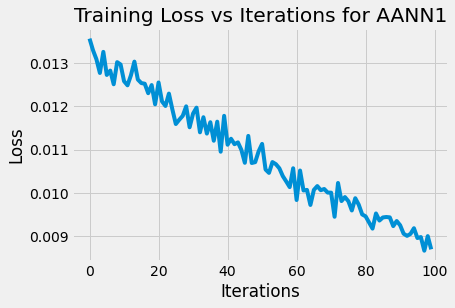

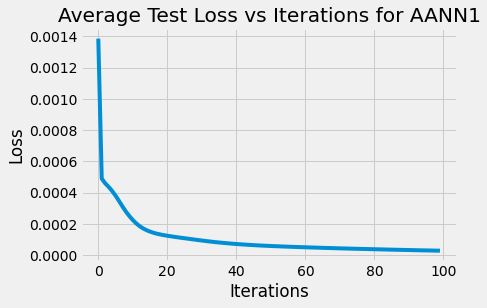

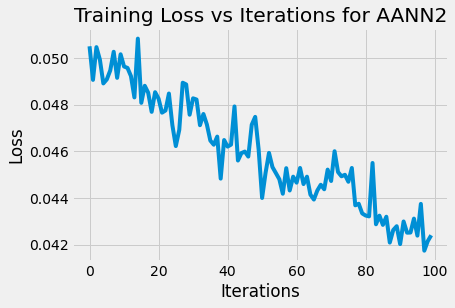

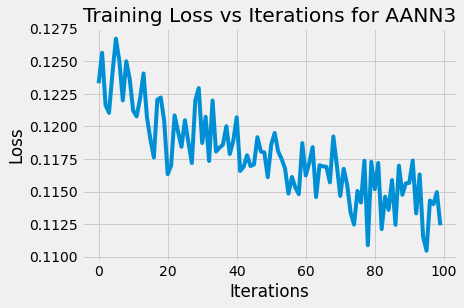

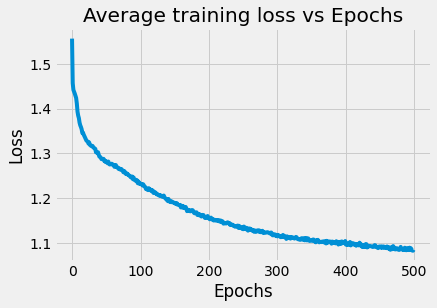

In [49]:
# Final model using the best parameters as obtained from above
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify = y)
train_dataloader = DataLoader(TensorDataset(torch.tensor(X_train), torch.tensor(y_train)), batch_size = 16, shuffle = True)
test_dataloader = DataLoader(TensorDataset(torch.tensor(X_test), torch.tensor(y_test)), batch_size = 16, shuffle = True)
SAE1, SAE2, SAE3 = TrainAE(3e-5, 3e-5, 3e-5)

model = StackedAutoEncoder()
model.to(device)
loss_function = nn.CrossEntropyLoss(reduction = 'mean')
optimizer = optim.Adam(model.parameters(), lr = 9e-4, weight_decay = 1e-8)

train_loss_list = list()
epochs = 500
accuracy_metrics = {
  'train': [],
  'test': []
}

for epoch in range(epochs):
    temp_loss_list = list()
    correct_classified = 0
    for x_train, y_train in train_dataloader:
        model.train()
        x_train = x_train.type(torch.float32).to(device)
        y_train = y_train.type(torch.long).to(device)
        optimizer.zero_grad()

        # Output of Autoencoder
        output = model(x_train)
        # Calculating the loss function
        loss = loss_function(output, y_train)
        loss.backward()
        optimizer.step()
        temp_loss_list.append(loss.detach().cpu().numpy())
        max_indices = torch.argmax(output, dim=1)
        correct_classified +=  (max_indices == y_train).float().sum()
          
        # Storing the losses in a list for plotting
    train_loss_list.append(np.average(temp_loss_list))
    accuracy_metrics["train"].append(correct_classified.item() / len(train_dataloader.dataset))
    print("epoch:", epoch)
    print("Train Accuracy: %.5f" %(correct_classified.item() / len(train_dataloader.dataset)))
  
correct_classified = 0
model.eval()
test_loss_list = list()
for X_test, y_test in test_dataloader:
    X_test = X_test.type(torch.float32).to(device)
    y_test = y_test.type(torch.long).to(device)

    score = model(X_test)
    loss = loss_function(input=score, target=y_test)

    test_loss_list.append(loss.detach().cpu().numpy())
    max_indices = torch.argmax(score, dim=1)
    correct_classified +=  (max_indices == y_test).float().sum()

accuracy_metrics["test"].append(correct_classified.item() / len(test_dataloader.dataset))
test_loss_list.append(np.average(test_loss_list))

print("Train average loss: %.5f" %train_loss_list[-1])
print("Test average loss: %.5f" %test_loss_list[-1])
print("Test Accuracy: %.5f" %accuracy_metrics['test'][0])

# Plot of average training loss in each epoch
plt.figure()
plt.style.use('fivethirtyeight')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Average training loss vs Epochs")
plt.plot(train_loss_list)



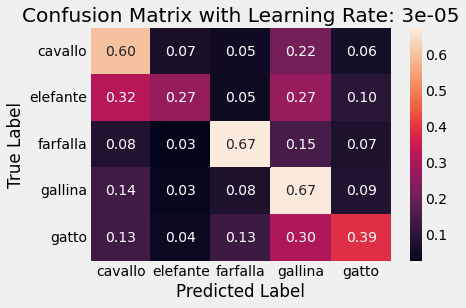

In [50]:
import seaborn as sns

idx_to_labels = ["cavallo", "elefante", "farfalla", "gallina", "gatto"]
lr = 3e-5
# Plotting the confusion matrix for the given classification
model.eval()
with torch.no_grad():
  confusion_matrix = torch.zeros(5, 5)
  for X_test, y_test in test_dataloader:
    X_test = X_test.type(torch.float32).to(device)
    y_test = y_test.type(torch.long).to(device)
    score = model(X_test)
    score = score.squeeze(dim=1)
    max_indices = torch.argmax(score, dim=1)
    for t, p in zip(y_test.cpu(), max_indices.cpu()):
      confusion_matrix[t.long(), p.long()] += 1
  
  for X_train, y_train in train_dataloader:
    X_train = X_train.type(torch.float32).to(device)
    y_train = y_train.type(torch.long).to(device)
    score = model(X_train)
    score = score.squeeze(dim=1)
    max_indices = torch.argmax(score, dim=1)
    for t, p in zip(y_train.cpu(), max_indices.cpu()):
      confusion_matrix[t.long(), p.long()] += 1
  
  confusion_matrix = confusion_matrix.numpy()
  confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
  
  #plt.figure(figsize=(5,4),dpi=300)
  sns.heatmap(confusion_matrix, annot=True,fmt='.2f', xticklabels=idx_to_labels, yticklabels=idx_to_labels)  
  
  plt.xlabel("Predicted Label")
  plt.ylabel("True Label")
  
  plt.title(f"Confusion Matrix with Learning Rate: {lr}")